In [2]:
using SeisIO, SeisNoise, Plots, CUDA, Glob, HDF5, PyPlot, Combinatorics, Statistics, Distributed

In [147]:
function preprocess_nodal!(S,freqmin,freqmax,downsample_fs=0)
        
    # preprocess the data
    detrend!(S)
    taper!(S)

    # filter the data
    fs = S.fs[1]
    bandpass!(S,freqmin,freqmax,zerophase=true)

    # downsample the data- this uses SeisIO's resample, not SeisNoise. Critically slow on gpu
    if downsample_fs != 0 && downsample_fs != S.fs[1]
        resample!(S,downsample_fs)
    end
    
    # whiten the data
    whiten!(S,freqmin,freqmax)

    # 1 bit normalization
    S.data .= sign.(S.data)
end


function correlate_windows(corr_mat,S,num_wins,win_size)
    for n in 1:num_wins
        win_start = Int64((n-1)*win_size*S.fs[1])+1
        win_end = Int64(n*win_size*S.fs[1])
        maxlag = Int(size(S.data[win_start:win_end,:])[1]/2-1)
        C = nodalxcorr(S.data[win_start:win_end,:],maxlag)
        corr_mat = corr_mat + C
    end
    return corr_mat
end

 
function profile_correlate(files,win_size,duration,chans,freqmin,freqmax)
    
    # read the first file and collect metadata
    S = SeisIO.read_nodal("segy", files[1])
    file_length = S.info["orignx"]
    num_files = Int64(duration/(file_length/S.fs[1]))
    corr_mat = zeros(Int64(win_size*fs)-1, Int64(size(chans)[1]*(size(chans)[1]-1)/2));
    num_wins = (size(S.data)[1]/(win_size*fs))
    
    # make containers for profiling
    io_times = zeros(num_files,1);
    preprocess_times = zeros(num_files,1);
    correlate_times = zeros(num_files,1);
    
    for i in 1:num_files

        # read the file
        io_time = @elapsed S = SeisIO.read_nodal("segy", files[i])[chans]
        io_times[i] = io_time

        if S.info["orignx"] == file_length

            # preprocess the data
            preprocess_time = @elapsed preprocess_nodal!(S,freqmin,freqmax)
            preprocess_times[i] = preprocess_time

            # loop through data in windows
            correlate_time = @elapsed corr_mat = correlate_windows(corr_mat,S,num_wins,win_size)
            correlate_times[i] = correlate_time
        end

    end
    return io_times,preprocess_times,correlate_times
end

profile_correlate (generic function with 1 method)

In [ ]:
# profile serial on cpu 

# list all the Greenland files (30 second files)
path = "/data/greenland/Store Glacier DAS data/1kHz"
files = glob("*",path)

# read the first file to get some metadata
S = SeisIO.read_nodal("segy", files[2])
fs = S.fs[1]
file_length = S.info["orignx"]/fs

# set channels to include
chans = collect(400:50:Int64(size(S.data)[2]/2))
#chans = prepend!(chans,50)
#chans = [50,100]

indices = [j for j in combinations(chans,2)]
indices = reduce(vcat,transpose.(indices))
distance_sort = sortperm(vec(diff(indices,dims=2)))
indices = indices[distance_sort,:]

# set total time in seconds
duration = 30

# set window size
win_size = 10

# set filter parameters
freqmin, freqmax = 1,50

# set number of channels to correlate
num_chans = 10

# make containers for profiling
io_times = zeros(num_chans,1);
preprocess_times = zeros(num_chans,1);
correlate_times = zeros(num_chans,1);
total_times = zeros(num_chans,1);

# run cross correlations
for c = 1:num_chans
    chans = collect(1:c*10)
    io_t,preprocess_t,correlate_t = profile_correlate(files[2:end],win_size,duration,chans,freqmin,freqmax)
    io_times[c] = mean(io_t)
    preprocess_times[c] = mean(preprocess_t)
    correlate_times[c] = mean(correlate_t)
    total_times[c] = mean(io_t) + mean(preprocess_t) + mean(correlate_t)
end

In [ ]:
# plot results
plt.figure()
plt.plot(1:num_chans,correlate_times,label="Correlation")
plt.plot(1:num_chans,io_times,label="IO")
plt.plot(1:num_chans,preprocess_times,label="Preprocessing")
plt.xlabel("Number of channels")
plt.ylabel("Runtime (s)")
plt.title("DAS Correlation runtime (serial)")
plt.legend()
plt.show()

In [ ]:
# lowest loop-level parallel cpu functions
@everywhere function correlate_single_window(S,win_size,n)
    win_start = Int64((n-1)*win_size*S.fs[1])+1
    win_end = Int64(n*win_size*S.fs[1])
    maxlag = Int(size(S.data[win_start:win_end,:])[1]/2-1)
    data = S.data[win_start:win_end,:]
    C = nodalxcorr(data,maxlag)
    return C
end


function correlate_windows_parallel(corr_mat,S,num_wins,win_size)
    corrs = pmap(n -> correlate_single_window(S,win_size,n), 1:num_wins)
    corr_mat += sum(corrs)
    return corr_mat
end


function profile_parallel_correlate(files,win_size,duration,chans,freqmin,freqmax)
    
    # read the first file and collect metadata
    S = SeisIO.read_nodal("segy", files[1])
    file_length = S.info["orignx"]
    num_files = Int64(duration/(file_length/S.fs[1]))
    corr_mat = zeros(Int64(win_size*fs)-1, Int64(size(chans)[1]*(size(chans)[1]-1)/2));
    num_wins = (size(S.data)[1]/(win_size*fs))
    
    # make containers for profiling
    io_times = zeros(num_files,1);
    preprocess_times = zeros(num_files,1);
    correlate_times = zeros(num_files,1);
    
    for i in 1:num_files

        # read the file
        io_time = @elapsed S = SeisIO.read_nodal("segy", files[i])[chans]
        io_times[i] = io_time

        if S.info["orignx"] == file_length

            # preprocess the data
            preprocess_time = @elapsed preprocess_nodal!(S,freqmin,freqmax)
            preprocess_times[i] = preprocess_time

            # loop through data in windows
            correlate_time = @elapsed corr_mat = correlate_windows_parallel(corr_mat,S,num_wins,win_size)
            correlate_times[i] = correlate_time
        end

    end
    return io_times,preprocess_times,correlate_times
end

In [ ]:
# profile parallel on cpu 

# start parallel pool
addprocs()
@everywhere using SeisIO, SeisNoise, Plots, CUDA, Glob, HDF5, PyPlot, Combinatorics, Statistics, Distributed

# list all the Greenland files (30 second files)
path = "/data/greenland/Store Glacier DAS data/1kHz"
files = glob("*",path)

# read the first file to get some metadata
S = SeisIO.read_nodal("segy", files[2])
fs = S.fs[1]
file_length = S.info["orignx"]/fs

# set channels to include
chans = collect(400:50:Int64(size(S.data)[2]/2))
#chans = prepend!(chans,50)
#chans = [50,100]

indices = [j for j in combinations(chans,2)]
indices = reduce(vcat,transpose.(indices))
distance_sort = sortperm(vec(diff(indices,dims=2)))
indices = indices[distance_sort,:]

# set total time in seconds
duration = 30

# set window size
win_size = 10

# set filter parameters
freqmin, freqmax = 1,50

# set number of channels to correlate
num_chans = 10

# make containers for profiling
io_times = zeros(num_chans,1);
preprocess_times = zeros(num_chans,1);
correlate_times = zeros(num_chans,1);
total_times = zeros(num_chans,1);

# run cross correlations
for c = 1:num_chans
    chans = collect(1:c*10)
    io_t,preprocess_t,correlate_t = profile_parallel_correlate(files[2:end],win_size,duration,chans,freqmin,freqmax)
    io_times[c] = mean(io_t)
    preprocess_times[c] = mean(preprocess_t)
    correlate_times[c] = mean(correlate_t)
    total_times[c] = mean(io_t) + mean(preprocess_t) + mean(correlate_t)
end  

In [ ]:
# plot results
plt.figure()
plt.plot(1:num_chans,correlate_times,label="Correlation")
plt.plot(1:num_chans,io_times,label="IO")
plt.plot(1:num_chans,preprocess_times,label="Preprocessing")
plt.xlabel("Number of correlations per file")
plt.ylabel("Runtime (s)")
plt.title("DAS Correlation runtime (lowest loop-level parallel)")
plt.legend()
plt.show()

In [51]:
function correlate_windows_gpu(corr_mat,S,num_wins,win_size)
    for n in 1:num_wins
        win_start = Int64((n-1)*win_size*fs)+1
        win_end = Int64(n*win_size*fs)
        maxlag = Int(size(S.data[win_start:win_end,:])[1]/2-1)
        data = S.data[win_start:win_end,:]
        C = nodalxcorr(data,maxlag)
        corr_mat = corr_mat + C
    end
    return corr_mat
end


function profile_correlate_gpu(files,win_size,duration,chans,freqmin,freqmax)
    
    # read the first file and collect metadata
    S = SeisIO.read_nodal("segy", files[1])
    file_length = S.info["orignx"]
    num_files = Int64(duration/(file_length/S.fs[1]))
    corr_mat = zeros(Int64(win_size*fs)-1, Int64(size(chans)[1]*(size(chans)[1]-1)/2)) |> cu;
    num_wins = (size(S.data)[1]/(win_size*fs))
    
    # make containers for profiling
    io_times = zeros(num_files,1);
    preprocess_times = zeros(num_files,1);
    correlate_times = zeros(num_files,1);
    
    for i in 1:num_files

        # read the file
        io_time = @elapsed S = SeisIO.read_nodal("segy", files[i])[chans] |> gpu
        io_times[i] = io_time

        if S.info["orignx"] == file_length

            # preprocess the data
            preprocess_time = @elapsed preprocess_nodal!(S,freqmin,freqmax)
            preprocess_times[i] = preprocess_time

            # loop through data in windows
            correlate_time = @elapsed corr_mat = correlate_windows_gpu(corr_mat,S,num_wins,win_size)
            correlate_times[i] = correlate_time
        end

    end
    return io_times,preprocess_times,correlate_times
end

profile_correlate_gpu (generic function with 1 method)

In [56]:
# profile serial on gpu 

# list all the Greenland files (30 second files)
path = "/data/greenland/Store Glacier DAS data/1kHz"
files = glob("*",path)

# read the first file to get some metadata
S = SeisIO.read_nodal("segy", files[2])
fs = S.fs[1]
file_length = S.info["orignx"]/fs

# set channels to include
chans = collect(400:50:Int64(size(S.data)[2]/2))
#chans = prepend!(chans,50)
#chans = [50,100]

indices = [j for j in combinations(chans,2)]
indices = reduce(vcat,transpose.(indices))
distance_sort = sortperm(vec(diff(indices,dims=2)))
indices = indices[distance_sort,:]

# set total time in seconds
duration = 30

# set window size
win_size = 10

# set filter parameters
freqmin, freqmax = 1,50

# set number of channels to correlate
num_chans = 10

# make containers for profiling
io_times = zeros(num_chans,1);
preprocess_times = zeros(num_chans,1);
correlate_times = zeros(num_chans,1);
total_times = zeros(num_chans,1);

# run cross correlations
for c = 1:num_chans
    chans = collect(1:c*10)
    io_t,preprocess_t,correlate_t = profile_correlate_gpu(files[2:end],win_size,duration,chans,freqmin,freqmax)
    io_times[c] = mean(io_t)
    preprocess_times[c] = mean(preprocess_t)
    correlate_times[c] = mean(correlate_t)
    total_times[c] = mean(io_t) + mean(preprocess_t) + mean(correlate_t)
end

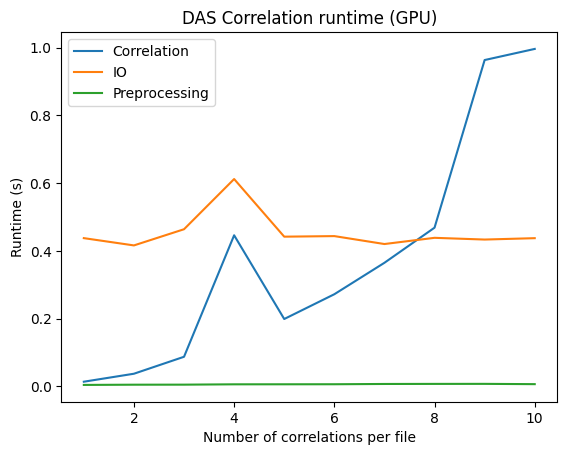

In [57]:
# plot results
plt.figure()
plt.plot(1:num_chans,correlate_times,label="Correlation")
plt.plot(1:num_chans,io_times,label="IO")
plt.plot(1:num_chans,preprocess_times,label="Preprocessing")
plt.xlabel("Number of correlations per file")
plt.ylabel("Runtime (s)")
plt.title("DAS Correlation runtime (GPU)")
plt.legend()
plt.show()

In [ ]:
# think about bytes/element of Float32 Array
max_n = 100
mem_vec = zeros(max_n)
for n=1:max_n
    test = zeros(Float32,n,n)
    mem = Base.summarysize(test)/n^2
    mem_vec[n] = mem
end

plt.plot(mem_vec)

In [ ]:
# list all the Greenland files (30 second files)
path = "/data/greenland/Store Glacier DAS data/1kHz"
files = glob("*",path)

# read the first file to get some metadata
S = SeisIO.read_nodal("segy", files[2])

# estimate size of array for maximum corrlation coefficient matrix
n = S.n
fs = S.fs[1]
bytes_per_element = 4
elements = n*(n-1)/2
total_bytes = elements*bytes_per_element
total_gigabytes = total_bytes / 1e9

# estimate size of array for input data
elements = n*S.info["orignx"]
total_bytes = elements*bytes_per_element
total_gigabytes = total_bytes / 1e9

# estimate size of array for output matrix (full resolution and maxlag)
elements = ((win_size*fs)-1)*(n*(n-1)/2)
total_bytes = elements*bytes_per_element
total_gigabytes = total_bytes / 1e9

# estimate size of array for output matrix (downsample to 100hz and 1s maxlag)
elements = ((win_size*fs/5/10)-1)*(n*(n-1)/2)
total_bytes = elements*bytes_per_element
total_gigabytes = total_bytes / 1e9

In [320]:
function preprocess_nodal_gpu!(S,freqmin,freqmax)
    
    # preprocess the data on gpu
    detrend!(S)
    taper!(S)

    # filter the data on gpu
    fs = S.fs[1]
    bandpass!(S,freqmin,freqmax,zerophase=true)

    # whiten the data
    whiten!(S,freqmin,freqmax)

    # 1 bit normalization
    S.data .= sign.(S.data)
end


function resample_nodal!(S,downsample_fs)
    C = CorrData(corr=S.data,fs=S.fs[1])
    resample!(C,downsample_fs)
    S.data = C.corr
    S.fs = ones(S.n)*downsample_fs
end


function correlate_windows_gpu_downsample(corr_mat,S,num_wins,win_size,maxlag)
    for n in 1:num_wins
        win_start = Int64((n-1)*win_size*S.fs[1])+1
        win_end = Int64(n*win_size*S.fs[1])
        data = S.data[win_start:win_end,:]
        C = nodalxcorr(data,maxlag)
        corr_mat = corr_mat + C
    end
    return corr_mat
end


function profile_correlate_gpu_downsample(files,win_size,maxlag,duration,chans,freqmin,freqmax,downsample_fs)
    
    # read the first file and collect metadata
    S = SeisIO.read_nodal("segy", files[1])
    file_length = S.info["orignx"]
    num_files = Int64(duration/(file_length/S.fs[1]))
    num_wins = (file_length/(win_size*S.fs[1]))

    maxlag = Int64(maxlag*downsample_fs)
    corr_mat = zeros(Int64(maxlag*2+1), Int64(size(chans)[1]*(size(chans)[1]-1)/2)) |> cu;
    
    # make containers for profiling
    io_times = zeros(num_files,1);
    preprocess_times = zeros(num_files,1);
    correlate_times = zeros(num_files,1);
    
    for i in 1:num_files

        # read the file
        io_time = @elapsed S = SeisIO.read_nodal("segy", files[i])[chans]
        io_times[i] = io_time
        
        if S.info["orignx"] == file_length

            # downsample the data- this uses SeisIO's resample, not SeisNoise. Critically slow on gpu.
            # it may not be okay for this to be first
            # it's here so we can still get gpu speed for the other preprocessing functions
            if downsample_fs != 0 && downsample_fs != S.fs[1]
                resample_nodal!(S,downsample_fs)
            end
            S = S |> gpu
            
            # preprocess the data
            preprocess_time = @elapsed preprocess_nodal_gpu!(S,freqmin,freqmax,downsample_fs)
            preprocess_times[i] = preprocess_time
            
            # loop through data in windows
            correlate_time = @elapsed corr_mat = correlate_windows_gpu_downsample(corr_mat,S,num_wins,win_size,maxlag)
            correlate_times[i] = correlate_time
        end

    end
    return io_times,preprocess_times,correlate_times
end

profile_correlate_gpu_downsample (generic function with 1 method)

In [327]:
# profile downsampled on gpu 

# list all the Greenland files (30 second files)
path = "/data/greenland/Store Glacier DAS data/1kHz"
files = glob("*",path)

# read the first file to get some metadata
S = SeisIO.read_nodal("segy", files[2])
fs = S.fs[1]
file_length = S.info["orignx"]/fs

indices = [j for j in combinations(chans,2)]
indices = reduce(vcat,transpose.(indices))
distance_sort = sortperm(vec(diff(indices,dims=2)))
indices = indices[distance_sort,:]

# set total time in seconds
duration = 30

# set window size
win_size = 10

# set filter parameters
freqmin, freqmax = 1,20
downsample_fs = freqmax*2+1.

# set maxlag in seconds
maxlag = 1

# set number of channels to correlate
num_chans = 500
chunk = 100

# make containers for profiling
sz = length(1:chunk:num_chans)
io_times = zeros(sz,1);
preprocess_times = zeros(sz,1);
correlate_times = zeros(sz,1);
total_times = zeros(sz,1);

# run cross correlations
i = 1
for c = 1:chunk:num_chans
    chans = collect(1:c)
    io_t,preprocess_t,correlate_t = profile_correlate_gpu_downsample(files[2:end],win_size,maxlag,duration,chans,freqmin,freqmax,downsample_fs)
    io_times[i] = mean(io_t)
    preprocess_times[i] = mean(preprocess_t)
    correlate_times[i] = mean(correlate_t)
    total_times[i] = mean(io_t) + mean(preprocess_t) + mean(correlate_t)
    i+=1
end

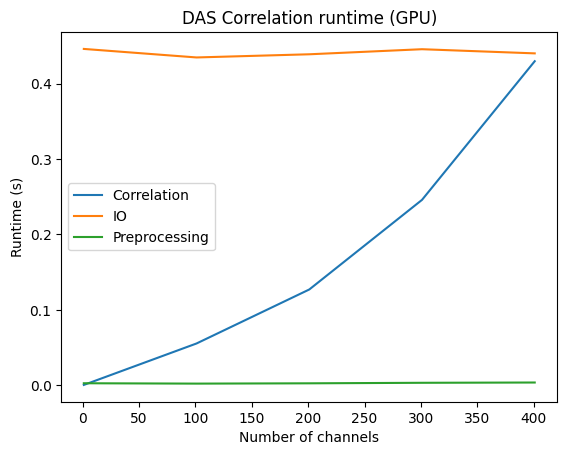

In [328]:
# plot results
plt.figure()
plt.plot(1:chunk:num_chans,correlate_times,label="Correlation")
plt.plot(1:chunk:num_chans,io_times,label="IO")
plt.plot(1:chunk:num_chans,preprocess_times,label="Preprocessing")
plt.xlabel("Number of channels")
plt.ylabel("Runtime (s)")
plt.title("DAS Correlation runtime (GPU)")
plt.legend()
plt.show()

In [329]:
# time per correlation
time_per_corr = total_times[end]/(num_chans*(num_chans-1)/2)
corr_per_file = S.n*(S.n-1)/2
time_per_file = time_per_corr * corr_per_file
num_files = 86400*3/30
num_cores = 8
total_time = num_files*time_per_file/num_cores
total_hours = total_time/3600

7.588963701308229

In [282]:
# choose original fs and new fs
fs = 100.
resample_fs = 10.

# generate some 'data'
data = rand(100,100)

# resample on cpu
C = CorrData(corr=data,fs=fs)
cpu_time = @elapsed resample!(C,resample_fs)

# resample on gpu
C = CorrData(corr=data,fs=fs) |> gpu
gpu_time = @elapsed resample!(C,resample_fs)

# print results
print("CPU time: ", cpu_time, " s\n")
print("GPU time: ", gpu_time, " s\n")

CPU time: 0.010855837 s
GPU time: 3.244542713 s


In [267]:
# choose original fs and new fs
fs = 100.
resample_fs = 10.

# generate some 'data'
sz = 500
data = rand(Float32,sz,sz)

# resample on cpu
C = CorrData(corr=data,fs=fs)
corr_time = @elapsed SeisNoise.resample!(C,resample_fs)

# resample on gpu
S = SeisNoise.NodalData()
S.data=data
S.fs=ones(sz).*fs
nodal_time = @elapsed SeisNoise.resample!(S,resample_fs)

# print results
print("CorrData time: ", corr_time, " s\n")
print("NodalData time: ", nodal_time, " s\n")

# verify the results are almost identical
print("Total difference: ",sum(C.corr-S.data))

CorrData time: 0.032703704 s
NodalData time: 3.133497156 s
Total difference: 7.137656e-6